In [2]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [3]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_9")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from session_9.utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from cifar10.model import Model_Net, model_summary, model_train, model_test
from cifar10.data_loader import load_cifar10_data
from session_9.visualization_utils import FeatureVisualization, build_confusion_matrix

Allocate GPU

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar_10_model = Model_Net(base_channels=3,num_classes=10).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))
#from torchviz import make_dot
#x = torch.zeros(1,3,32,32,dtype=torch.float, requires_grad=False)
#y  = cifar_10_model(x)
#cifar_model_dot = make_dot(y.mean(), params = dict(list(cifar_10_model.named_parameters())))
#cifar_model_dot.format='png'
#cifar_model_dot.render("model_dot_representation.png")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]             576
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           4,096
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
          Dropout-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

/content/ERA_V1/session_9/cifar10/model.py:286: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [5]:
train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.05, rotate_limit=10.,p=0.5),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=16,
                                                max_width=16, min_holes = 1,
                                                min_height=16, min_width=16,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [6]:
torch.manual_seed(1)
batch_size = 64
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

100%|██████████| 170498071/170498071 [00:12<00:00, 13169041.79it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Show sample Images from the dataset

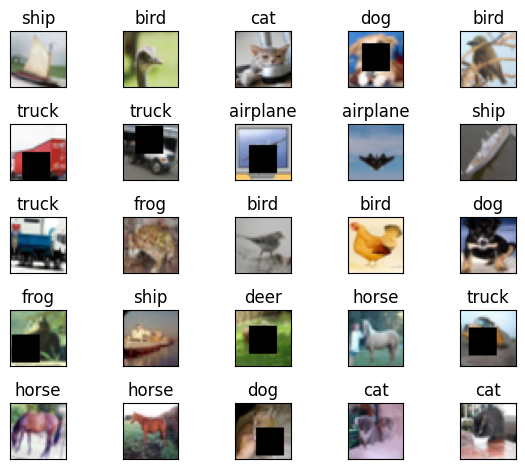

In [7]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

In [8]:
drop_out = 0.05
num_epochs=30
model_bn = Model_Net(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.1,verbose=True)
train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model_bn, device, train_loader, optimizer, train_acc_bn, train_losses_bn)
    this_loss = model_test(model_bn, device, test_loader, test_acc_bn, test_losses_bn)
    scheduler.step(this_loss)
target_test_acc = 85.


epoch: 1


loss=1.4437804222106934 batch_id=781 Accuracy = 42.64: 100%|██████████| 782/782 [00:38<00:00, 20.16it/s]



Test set: Average loss: 1.1307, Accuracy: 5874/10000 (58.74%)

epoch: 2


loss=0.7302495837211609 batch_id=781 Accuracy = 58.16: 100%|██████████| 782/782 [00:39<00:00, 19.82it/s]



Test set: Average loss: 1.0817, Accuracy: 6296/10000 (62.96%)

epoch: 3


loss=0.9768984913825989 batch_id=781 Accuracy = 63.98: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]



Test set: Average loss: 0.7780, Accuracy: 7238/10000 (72.38%)

epoch: 4


loss=0.5081634521484375 batch_id=781 Accuracy = 67.14: 100%|██████████| 782/782 [00:40<00:00, 19.43it/s]



Test set: Average loss: 0.7473, Accuracy: 7360/10000 (73.60%)

epoch: 5


loss=1.0461516380310059 batch_id=781 Accuracy = 69.33: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]



Test set: Average loss: 0.7268, Accuracy: 7513/10000 (75.13%)

epoch: 6


loss=0.930726170539856 batch_id=781 Accuracy = 71.32: 100%|██████████| 782/782 [00:40<00:00, 19.46it/s]



Test set: Average loss: 0.6419, Accuracy: 7817/10000 (78.17%)

epoch: 7


loss=0.945835530757904 batch_id=781 Accuracy = 72.37: 100%|██████████| 782/782 [00:40<00:00, 19.49it/s]



Test set: Average loss: 0.6172, Accuracy: 7852/10000 (78.52%)

epoch: 8


loss=0.9177873134613037 batch_id=781 Accuracy = 73.40: 100%|██████████| 782/782 [00:40<00:00, 19.52it/s]



Test set: Average loss: 0.5826, Accuracy: 7980/10000 (79.80%)

epoch: 9


loss=0.4500197768211365 batch_id=781 Accuracy = 74.37: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]



Test set: Average loss: 0.6125, Accuracy: 7875/10000 (78.75%)

epoch: 10


loss=0.36840716004371643 batch_id=781 Accuracy = 75.00: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]



Test set: Average loss: 0.5502, Accuracy: 8093/10000 (80.93%)

epoch: 11


loss=0.6534560322761536 batch_id=781 Accuracy = 75.96: 100%|██████████| 782/782 [00:39<00:00, 19.63it/s]



Test set: Average loss: 0.5458, Accuracy: 8100/10000 (81.00%)

epoch: 12


loss=0.6841306686401367 batch_id=781 Accuracy = 76.34: 100%|██████████| 782/782 [00:40<00:00, 19.54it/s]



Test set: Average loss: 0.5903, Accuracy: 8060/10000 (80.60%)

epoch: 13


loss=1.1622023582458496 batch_id=781 Accuracy = 76.95: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]



Test set: Average loss: 0.5189, Accuracy: 8220/10000 (82.20%)

epoch: 14


loss=0.8891463875770569 batch_id=781 Accuracy = 77.36: 100%|██████████| 782/782 [00:40<00:00, 19.37it/s]



Test set: Average loss: 0.5347, Accuracy: 8190/10000 (81.90%)

epoch: 15


loss=1.2250733375549316 batch_id=781 Accuracy = 77.43: 100%|██████████| 782/782 [00:39<00:00, 19.62it/s]



Test set: Average loss: 0.5309, Accuracy: 8209/10000 (82.09%)

Epoch 00015: reducing learning rate of group 0 to 1.0000e-03.
epoch: 16


loss=1.0119755268096924 batch_id=781 Accuracy = 79.97: 100%|██████████| 782/782 [00:39<00:00, 19.56it/s]



Test set: Average loss: 0.4419, Accuracy: 8458/10000 (84.58%)

epoch: 17


loss=0.5899626016616821 batch_id=781 Accuracy = 80.86: 100%|██████████| 782/782 [00:39<00:00, 19.57it/s]



Test set: Average loss: 0.4363, Accuracy: 8511/10000 (85.11%)

epoch: 18


loss=0.9783360362052917 batch_id=781 Accuracy = 80.94: 100%|██████████| 782/782 [00:40<00:00, 19.47it/s]



Test set: Average loss: 0.4413, Accuracy: 8485/10000 (84.85%)

epoch: 19


loss=0.7908288836479187 batch_id=781 Accuracy = 81.01: 100%|██████████| 782/782 [00:40<00:00, 19.28it/s]



Test set: Average loss: 0.4273, Accuracy: 8534/10000 (85.34%)

epoch: 20


loss=0.7216019034385681 batch_id=781 Accuracy = 81.37: 100%|██████████| 782/782 [00:40<00:00, 19.46it/s]



Test set: Average loss: 0.4309, Accuracy: 8535/10000 (85.35%)

epoch: 21


loss=0.7756726145744324 batch_id=781 Accuracy = 81.05: 100%|██████████| 782/782 [00:40<00:00, 19.35it/s]



Test set: Average loss: 0.4246, Accuracy: 8550/10000 (85.50%)

Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
epoch: 22


loss=0.7617453336715698 batch_id=781 Accuracy = 81.88: 100%|██████████| 782/782 [00:40<00:00, 19.46it/s]



Test set: Average loss: 0.4210, Accuracy: 8575/10000 (85.75%)

epoch: 23


loss=0.6902719736099243 batch_id=781 Accuracy = 81.73: 100%|██████████| 782/782 [00:40<00:00, 19.50it/s]



Test set: Average loss: 0.4234, Accuracy: 8575/10000 (85.75%)

epoch: 24


loss=0.9604810476303101 batch_id=781 Accuracy = 81.76: 100%|██████████| 782/782 [00:41<00:00, 19.03it/s]



Test set: Average loss: 0.4199, Accuracy: 8580/10000 (85.80%)

epoch: 25


loss=0.7436203360557556 batch_id=781 Accuracy = 81.88: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]



Test set: Average loss: 0.4199, Accuracy: 8577/10000 (85.77%)

epoch: 26


loss=0.6777786612510681 batch_id=781 Accuracy = 81.89: 100%|██████████| 782/782 [00:40<00:00, 19.36it/s]



Test set: Average loss: 0.4191, Accuracy: 8578/10000 (85.78%)

Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.
epoch: 27


loss=0.5625736713409424 batch_id=781 Accuracy = 81.85: 100%|██████████| 782/782 [00:39<00:00, 19.55it/s]



Test set: Average loss: 0.4199, Accuracy: 8573/10000 (85.73%)

epoch: 28


loss=0.6282879114151001 batch_id=781 Accuracy = 81.89: 100%|██████████| 782/782 [00:40<00:00, 19.45it/s]



Test set: Average loss: 0.4199, Accuracy: 8587/10000 (85.87%)

epoch: 29


loss=0.5275736451148987 batch_id=781 Accuracy = 81.97: 100%|██████████| 782/782 [00:40<00:00, 19.22it/s]



Test set: Average loss: 0.4221, Accuracy: 8582/10000 (85.82%)

epoch: 30


loss=0.3171467185020447 batch_id=781 Accuracy = 81.85: 100%|██████████| 782/782 [00:40<00:00, 19.49it/s]



Test set: Average loss: 0.4242, Accuracy: 8581/10000 (85.81%)



Plot results for Batch Norm experiment

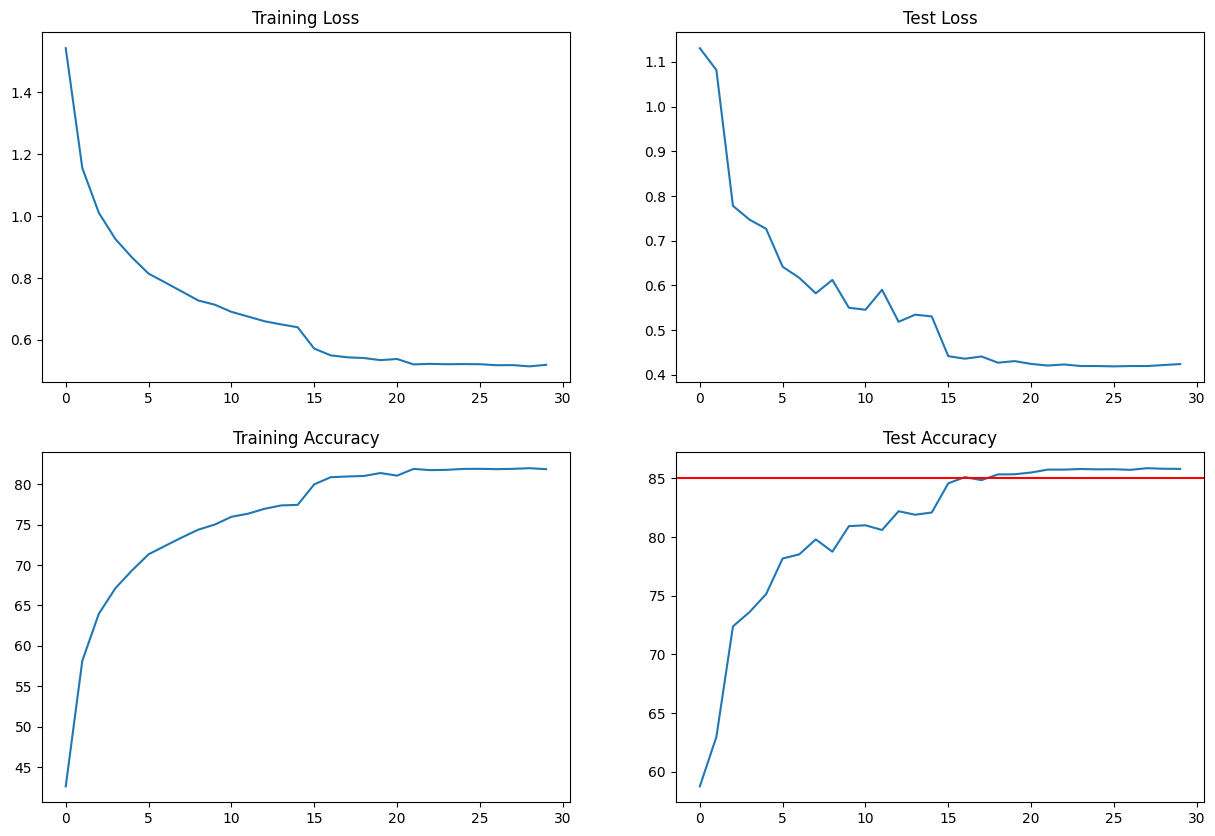

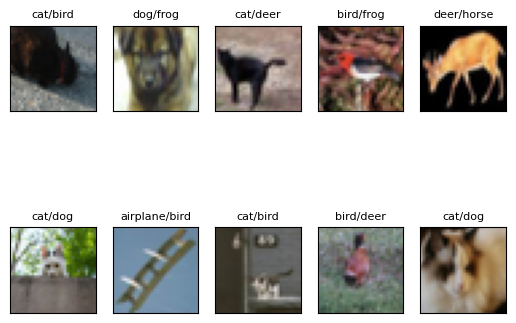

In [9]:
plot_statistics(train_losses_bn, train_acc_bn, test_losses_bn, test_acc_bn, target_test_acc)
incorrect_predictions_bn = get_incorrect_predictions(model_bn, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)

Print Training Log

In [56]:
def print_train_log(train_acc, test_acc, train_loss, test_loss):
    print(f"\nEpoch\t     Train Loss\t     Val Loss     Train Accuracy    Val Accuracy")
    print(f"========================================================================")
    for cnt in range(len(train_acc)):
        print(f"{cnt+1}\t\t{train_loss[cnt]:0.2f}\t\t{test_loss[cnt]:0.2f}\t\t{train_acc[cnt]:0.2f}\t\t{test_acc[cnt]:0.2f}\n")

    print(f"=========================================================================")


In [57]:
print_train_log(train_acc_bn, test_acc_bn, train_losses_bn, test_losses_bn)


Epoch	     Train Loss	     Val Loss     Train Accuracy    Val Accuracy
1		1.54		1.13		42.64		58.74

2		1.16		1.08		58.16		62.96

3		1.01		0.78		63.98		72.38

4		0.93		0.75		67.14		73.60

5		0.87		0.73		69.33		75.13

6		0.81		0.64		71.32		78.17

7		0.79		0.62		72.37		78.52

8		0.76		0.58		73.40		79.80

9		0.73		0.61		74.37		78.75

10		0.71		0.55		75.00		80.93

11		0.69		0.55		75.96		81.00

12		0.68		0.59		76.34		80.60

13		0.66		0.52		76.95		82.20

14		0.65		0.53		77.36		81.90

15		0.64		0.53		77.43		82.09

16		0.57		0.44		79.97		84.58

17		0.55		0.44		80.86		85.11

18		0.54		0.44		80.94		84.85

19		0.54		0.43		81.01		85.34

20		0.53		0.43		81.37		85.35

21		0.54		0.42		81.05		85.50

22		0.52		0.42		81.88		85.75

23		0.52		0.42		81.73		85.75

24		0.52		0.42		81.76		85.80

25		0.52		0.42		81.88		85.77

26		0.52		0.42		81.89		85.78

27		0.52		0.42		81.85		85.73

28		0.52		0.42		81.89		85.87

29		0.51		0.42		81.97		85.82

30		0.52		0.42		81.85		85.81



In [ ]:
build_confusion_matrix(model_bn, test_loader)